## Imports
utilities.py contains a number of useful functions including loading credentials from a json file, retrieving files from S3, and defining thecurrent list of brains that are associated with the Active Atlas.

In [1]:
import datajoint as dj  # automatically loads dj.config from the file `dj_local_conf.json` if it exists
import numpy as np
import json
from subprocess import call
import yaml
import sys, os
import pandas as pd

sys.path.append('./lib')
from utilities import *
from initialization_of_db import *

## Load Credentials, Connect to Database
User needs to supply credentials to connect to the dj server and to S3.

1. The master file is in `setup/credFiles.yaml`. This file contains pointers to the dj and S3 credentials. A typical contant is 
``` yaml
aws_fp: /Users/yoavfreund/VaultBrain/s3-creds.json
dj_fp: /Users/yoavfreund/VaultBrain/dj_local_conf.json
```

2. A redacted content of the json file `aws_fp` is:
```json
{"access_key": "XXXX", 
"secret_key": "SSSSSSS"}
```

3. A redacted content of the json file `dj_fp` is 
```json
{
    "database.host": "ucsd-demo-db.datajoint.io",
    "database.password": "XXXXXXXXXXX",
    "database.user": "yoav",
    "database.port": 3306,
    "database.reconnect": false,
    "connection.init_function": null,
    "connection.charset": "",
    "loglevel": "INFO",
    "safemode": true,
    "display.limit": 7,
    "display.width": 14,
    "display.show_tuple_count": true,
    "history": [
        "No config file found, using default settings.",
        "Updated from config file: dj_local_conf.json"
    ]
}
```

In [2]:
# Load Datajoint Credentials
# `dj_creds` needs the following fields: 'user', 'passwd'
# Then set necessary fields in dj.config

# Cannot directly set 'dj.config' equal to the json file as it is a special datajoint object
dj.config['database.host'] = get_dj_creds()['database.host']
dj.config['database.user'] = get_dj_creds()['database.user']
dj.config['database.port'] = get_dj_creds()['database.port']
dj.config['database.password'] = get_dj_creds()['database.password']

# Will save a json file in this directory (ignored by git) with credentials. Won't need to load them again
dj.config.save_local()

In [2]:
# Connect to datajoint server
dj.conn()

Connecting dbadmin@ucsd-demo-db.datajoint.io:3306


DataJoint connection (connected) dbadmin@ucsd-demo-db.datajoint.io:3306

In [4]:
# Define which schema you're using
schema = dj.schema('conrad_test')
schema.spawn_missing_classes()

#dj.ERD(schema)

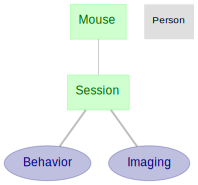

In [5]:
dj.ERD(schema)

In [27]:
print('________ Mouse ________')
Mouse.describe()
print('________ Person ________')
Person.describe()
print('________ Session ________')
Session.describe()
print('________ Behavior ________')
Behavior.describe();
print('________ Imaging ________')
Imaging.describe();

________ Mouse ________
# Mouse in the lab
mouse_id             : char(8)                      # unique mouse id - CF_Sensor_number
---
dob                  : date                         # Date of birth
iacuc_barcode        : bigint unsigned              # The IACUC barcode on the cage
sex="M"              : enum('M','F')                # The mouse gender
genotype="C57/Bl6"   : varchar(1000)                # The mouse strain

________ Person ________
username             : varchar(16)                  
---
full_name            : varchar(30)                  

________ Session ________
-> Mouse
session              : tinyint unsigned             # The session number
---
path_to_tiff         : varchar(1000)                # Two photon tiff file
path_to_adi          : varchar(1000)                # Labchart file with behavioural data
adi_trial_num        : tinyint                      # The session number in the adicht file associated with this session
session_date         : date        

In [26]:
print('________ Mouse ________')
Mouse.describe()
print('________ Histology ________')
Histology.describe()
print('________ Stack ________')
Stack.describe()
print('________ Slice ________')
Slice.describe();

________ Mouse ________
# Mouse in the lab
mouse_id             : char(8)                      # unique mouse id - CF_Sensor_number
---
dob                  : date                         # Date of birth
iacuc_barcode        : bigint unsigned              # The IACUC barcode on the cage
sex="M"              : enum('M','F')                # The mouse gender
genotype="C57/Bl6"   : varchar(1000)                # The mouse strain

________ Histology ________


NameError: name 'Histology' is not defined

## extracting rows as pandas dataframe

In [4]:
brainStackTable = Stack.fetch(as_dict=True)
brainStackDF = pd.DataFrame(brainStackTable)
brainStackDF.head()

,mouse,stack_name,num_slices,num_valid_slices,channels,human_annotated,planar_resolution_um,section_thickness_um
0,CHATM2,CHATM2,328,235,2,0,0.46,20.0
1,CHATM3,CHATM3,413,293,2,0,0.46,20.0
2,CSHL2,CSHL2,-1,-1,1,0,0.46,20.0
3,MD175,MD175,-1,-1,1,0,0.46,20.0
4,MD585,MD585,447,439,1,1,0.46,20.0


#### Todo
Sorted_filenames is no longer relevant, should create a table without this column.

In [5]:
HistologyTable = Histology.fetch( as_dict=True )
HistologyDF=pd.DataFrame.from_dict(HistologyTable)
print(HistologyDF.shape)
HistologyDF.head()

(27, 7)


,mouse,region,thickness,orientation,counter_stain,lab,series
0,CHATM2,Unknown,20,sagittal,NTB/ChAT,UCSD,unknown
1,CHATM3,Unknown,20,sagittal,NTB/ChAT,UCSD,unknown
2,CSHL2,Unknown,20,sagittal,?,UCSD,unknown
3,MD175,Unknown,20,coronal,thionin,CSHL,unknown
4,MD585,Unknown,20,sagittal,thionin,CSHL,unknown


## List relevant info for given stack
#### - Example displaying MD585 sections


In [8]:
stack = 'MD585'
ThisBrain=brainStackDF[brainStackDF['mouse']==stack]
ThisBrain[['mouse','stack_name','num_slices','channels']]

,mouse,stack_name,num_slices,channels
4,MD585,MD585,-1,1


In [13]:
ThisHistology=HistologyDF[HistologyDF['mouse']==stack]
ThisHistology

,mouse,region,thickness,orientation,counter_stain,lab,series
4,MD585,Unknown,20,sagittal,thionin,CSHL,unknown


## Access Raw & Processed Data
#### - Example accessing MD585 data

In [39]:
# Gives a List of Dictionaries. Each element in the list is a new slice.
#These_slices = (Slice&dict(mouse=stack,valid=1)).fetch( as_dict=True )
These_slices = (Slice&dict(valid=1)).fetch( as_dict=True )
SlicesDF=pd.DataFrame.from_dict(These_slices)
SlicesDF=SlicesDF.set_index('slice_num')
print('all valid=',SlicesDF.shape)
with_raw = SlicesDF[SlicesDF['raw_s3_fp']!='']
with_raw_and_processed = with_raw[with_raw['processed_s3_fp']!='']
print('valid and raw_s3_fp defined',with_raw.shape)
print('valid and raw and processed defined',with_raw_and_processed.shape)
with_raw_and_processed.head()

all valid= (9830, 5)
valid and raw_s3_fp defined (9251, 5)
valid and raw and processed defined (5419, 5)


,mouse,slice_name,valid,raw_s3_fp,processed_s3_fp
slice_num,,,,,
83,MD585,MD585-N16-2015.07.16-20.32.33_MD585_2_0047,1,CSHL_data/MD585/MD585-N16-2015.07.16-20.32.33_...,CSHL_data_processed/MD585/MD585_prep2_lossless...
84,MD585,MD585-IHC16-2015.08.19-13.14.51_MD585_3_0048,1,CSHL_data/MD585/MD585-IHC16-2015.08.19-13.14.5...,CSHL_data_processed/MD585/MD585_prep2_lossless...
85,MD585,MD585-N17-2015.07.16-20.35.23_MD585_1_0049,1,CSHL_data/MD585/MD585-N17-2015.07.16-20.35.23_...,CSHL_data_processed/MD585/MD585_prep2_lossless...
86,MD585,MD585-IHC17-2015.07.16-15.32.03_MD585_1_0049,1,CSHL_data/MD585/MD585-IHC17-2015.07.16-15.32.0...,CSHL_data_processed/MD585/MD585_prep2_lossless...
87,MD585,MD585-N17-2015.07.16-20.35.23_MD585_2_0050,1,CSHL_data/MD585/MD585-N17-2015.07.16-20.35.23_...,CSHL_data_processed/MD585/MD585_prep2_lossless...


* 9830 slices are valid


In [21]:
slice_index = 200
SliceInfo=SlicesDF.loc[slice_index,:]
SliceInfo

mouse                                                          MD585
slice_name              MD585-IHC36-2015.08.19-13.58.57_MD585_1_0106
valid                                                              1
raw_s3_fp          CSHL_data/MD585/MD585-IHC36-2015.08.19-13.58.5...
processed_s3_fp    CSHL_data_processed/MD585/MD585_prep2_lossless...
Name: 200, dtype: object

# Download Images from S3 to Local Computer
(Relies on `bucket` and `filename_list` from previous cell)

In [22]:
from subprocess import call

# S3 bucket must be appended to the s3_fp
def download_from_s3(s3_fp, local_root=os.environ['DWNLD_ROOT_DIR'], raw=False):
    if raw:
        s3_url = "s3://"+os.environ['BUCKET_RAWDATA']+"/" + s3_fp
    else:
        s3_url = "s3://"+os.environ['BUCKET_DATA']+"/" + s3_fp
    local_download_fp = local_root + s3_fp
    
    print("aws "+"s3 "+"cp "+s3_url+' '+local_download_fp)

    call(["aws",\
          "s3",\
          "cp",\
          s3_url,\
          local_download_fp])


In [27]:
# DOWNLOAD PROCESSED FILE
s3_fp=SlicesDF.loc[200,'processed_s3_fp']
print('downloading',s3_fp)
# Downloads to `DWNLD_ROOT_DIR` set in setup/config.sh by default
download_from_s3( s3_fp, raw=False)

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC36-2015.08.19-13.58.57_MD585_1_0106_prep2_lossless.tif /Users/yoavfreund/projects/shapeology/data/CSHL_data_processed/MD585/MD585_prep2_lossless/MD585-IHC36-2015.08.19-13.58.57_MD585_1_0106_prep2_lossless.tif


In [28]:
# DOWNLOAD RAW FILE
s3_fp=SlicesDF.loc[200,'raw_s3_fp']
print('downloading',s3_fp)

#download_from_s3( s3_fp, raw=True)

downloading CSHL_data/MD585/MD585-IHC36-2015.08.19-13.58.57_MD585_1_0106_lossless.jp2
